In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

OPEN_INTEREST_FILE = "./useful_data/market_open_interest_with_timestamps.csv"
BORROWING_FILE     = "./useful_data/market_borrowing_with_timestamps.csv"

NA_MARKERS = ["", " ", "nan", "NaN", "NAN", "inf", "Inf", "INF", "+inf", "-inf"]

def load_and_clean(path: str | Path) -> pd.DataFrame:
    """Read a CSV whose `timestamp` looks like '1625072400.0', fix it, return a frame."""
    # 1️⃣  Read without dtype pressure; treat common tokens as NaN
    df = pd.read_csv(
        path,
        na_values=NA_MARKERS,
        keep_default_na=True,     # also "" / "#N/A" / "--" etc.
    )

    # 2️⃣  Coerce timestamp: float-ish strings → float64, bad → NaN
    df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

    # 3️⃣  Drop rows where timestamp couldn’t be parsed
    bad_ts_mask = df["timestamp"].isna()
    n_bad_ts    = bad_ts_mask.sum()
    if n_bad_ts:
        print(f"{path}: dropped {n_bad_ts} rows with bad/missing timestamp")
        df = df[~bad_ts_mask]

    # 4️⃣  Round away the trailing .0 (just defensive) & cast to int64
    df["timestamp"] = df["timestamp"].round().astype("int64")

    df.drop(columns=['market', 'blockNumber', 'datetime'], inplace=True)

    return df



In [2]:
oi_df = load_and_clean(OPEN_INTEREST_FILE)
borrowing_df = load_and_clean(BORROWING_FILE)

./useful_data/market_borrowing_with_timestamps.csv: dropped 2 rows with bad/missing timestamp


In [3]:
oi_df.head()

,collateral,next_value,delta,isLong,timestamp
0,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,8548490148598439959148774877577818649,-331771000000000000000000000000000000,False,1743317928
1,0xaf88d065e77c8cc2239327c5edb3a432268e5831,13472361291846885339811909027854886618,-1246375395826236954884375000000000,True,1743318778
2,0xaf88d065e77c8cc2239327c5edb3a432268e5831,13472364291846885339812250156706113242,3000000000000000341128851226624,True,1743318882
3,0xaf88d065e77c8cc2239327c5edb3a432268e5831,13472367291846885339812591285557339866,3000000000000000341128851226624,True,1743318978
4,0xaf88d065e77c8cc2239327c5edb3a432268e5831,6926963317178009233161331194198955781,7067814618490622309985196032000000,False,1743319787


In [4]:
# split oi_df based on different collaterals, and on isLong into 4 dataframes
oi_df_weth = oi_df[oi_df['collateral'] == '0x82af49447d8a07e3bd95bd0d56f35241523fbab1']
oi_df_usdc = oi_df[oi_df['collateral'] == '0xaf88d065e77c8cc2239327c5edb3a432268e5831']
oi_df_weth_long = oi_df_weth[oi_df_weth['isLong'] == True]
oi_df_weth_short = oi_df_weth[oi_df_weth['isLong'] == False]
oi_df_usdc_long = oi_df_usdc[oi_df_usdc['isLong'] == True]
oi_df_usdc_short = oi_df_usdc[oi_df_usdc['isLong'] == False]

assert len(oi_df_weth_long) + len(oi_df_weth_short) == len(oi_df_weth)
assert len(oi_df_usdc_long) + len(oi_df_usdc_short) == len(oi_df_usdc)
assert len(oi_df_weth_long) + len(oi_df_weth_short) + len(oi_df_usdc_long) + len(oi_df_usdc_short) == len(oi_df)

In [5]:
oi_df_weth_long.head()

,collateral,next_value,delta,isLong,timestamp
11,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,3061791936841816820123779277090080712,7739491783633825602271000000000000,True,1743321642
14,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,3054052445058182994521508277090080712,-7739491783633825602271000000000000,True,1743321954
20,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,3108378410168233268105900725090080712,54325965110050273584392448000000000,True,1743323738
38,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,3054052445058182994521508277090080712,-54325965110050273584392448000000000,True,1743330317
73,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,3054029408001087648527880851090080712,-23037057095345993627426000000000,True,1743340186


In [6]:
import pandas as pd

oi_dfs = {
    "oi_weth_long" : oi_df_weth_long,
    "oi_weth_short": oi_df_weth_short,
    "oi_usdc_long" : oi_df_usdc_long,
    "oi_usdc_short": oi_df_usdc_short,
}

cleaned_oi = {}                      # we’ll stash the prepared frames here

for tag, df in oi_dfs.items():
    df = df.copy()                # avoid SettingWithCopy surprises
    
    # ---------------------------------------------------------------
    # 1. Make sure “timestamp” is an *actual column* for dedup logic
    # ---------------------------------------------------------------
    if "timestamp" not in df.columns:
        # fall back to index if that’s where the timestamp lives
        if df.index.name is None:
            raise KeyError(
                f"No 'timestamp' column or index found in DataFrame {tag!r}"
            )
        df.reset_index(inplace=True)  # brings the index back as a column
    
    # ---------------------------------------------------------------
    # 2. Keep only the *latest* row for every timestamp
    # ---------------------------------------------------------------
    df.sort_values("timestamp", inplace=True)                   # chronological
    df.drop_duplicates("timestamp", keep="last", inplace=True)  # keep newest

    df.drop(columns=['collateral', 'isLong', 'delta'], inplace=True)
    
    # ---------------------------------------------------------------
    # 3. Put timestamp on the index and prefix all other columns
    # ---------------------------------------------------------------
    df.set_index("timestamp", inplace=True, drop=True)
    df.rename(columns=lambda c: f"{tag}_{c}", inplace=True)
    
    cleaned_oi[tag] = df

# -------------------------------------------------------------------
# 4. Outer-join all four on the index (timestamp) and forward-fill
# -------------------------------------------------------------------
merged_oi = (
    pd.concat(cleaned_oi.values(), axis=1)  # sparse outer join
      .sort_index()                      # chronological order
      .ffill()                           # carry last obs forward
)

merged_oi.head()

,oi_weth_long_next_value,oi_weth_short_next_value,oi_usdc_long_next_value,oi_usdc_short_next_value
timestamp,,,,
1743317928,NaN,8548490148598439959148774877577818649,NaN,NaN
1743318778,NaN,8548490148598439959148774877577818649,13472361291846885339811909027854886618,NaN
1743318882,NaN,8548490148598439959148774877577818649,13472364291846885339812250156706113242,NaN
1743318978,NaN,8548490148598439959148774877577818649,13472367291846885339812591285557339866,NaN
1743319787,NaN,8548490148598439959148774877577818649,13472367291846885339812591285557339866,6926963317178009233161331194198955781


In [7]:
merged_oi.dropna(inplace=True)

In [8]:
# ── 1 ── Ensure there is a 'timestamp' column
if "timestamp" not in merged_oi.columns:
    if merged_oi.index.name is None:
        raise KeyError("No 'timestamp' column or timestamp index found")
merged_oi = merged_oi.reset_index()                       # bring index into a column

# ── 2 ── Standardise timestamps to pandas datetime (nanosecond precision)
merged_oi["timestamp"] = pd.to_datetime(merged_oi["timestamp"], unit="s", errors="coerce")

In [9]:
len(merged_oi)

47015

In [10]:
merged_oi.head()

,timestamp,oi_weth_long_next_value,oi_weth_short_next_value,oi_usdc_long_next_value,oi_usdc_short_next_value
0,2025-03-30 08:00:42,3061791936841816820123779277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980013916479408225275581194198955781
1,2025-03-30 08:01:45,3061791936841816820123779277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980016916479408225275922323050182405
2,2025-03-30 08:03:27,3061791936841816820123779277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980487667382509257723922323050182405
3,2025-03-30 08:05:54,3054052445058182994521508277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980487667382509257723922323050182405
4,2025-03-30 08:10:40,3054052445058182994521508277090080712,8548490148598439959148774877577818649,13301130986724340398524610031985761618,6980487667382509257723922323050182405


In [11]:
borrowing_df.head()

,delta,nextValue,isLong,timestamp
0,4367060921656151964019466,215501323415704255202388315623,True,1743317928
1,0,79813929946893005470258731931,False,1743317928
2,210344347417999027262146,215501533760051673201415577769,True,1743317990
3,0,79813929946893005470258731931,False,1743317990
4,3392650908231486441225,215501537152702581432902018994,True,1743317991


In [12]:
print(len(borrowing_df))
# Drop rows where delta == 0
# print("MAYBE SHOULD RETURN THIS")
borrowing_df = borrowing_df[borrowing_df['delta'] != "0"]

print(len(borrowing_df))


111898
52958


In [13]:
borrowing_df.drop(columns=['nextValue'], inplace=True)

In [14]:
borrowing_rate_long = borrowing_df[borrowing_df['isLong'] == True]
borrowing_rate_short = borrowing_df[borrowing_df['isLong'] == False]
len(borrowing_rate_long), len(borrowing_rate_short)

(33771, 19187)

In [15]:
assert len(borrowing_rate_long) + len(borrowing_rate_short) == len(borrowing_df)

In [16]:
import numpy as np
import pandas as pd

GMX_PRECISION = 10**30           # unchanged

def compute_borrowing_rate(borrowing_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute borrowing factor-per-second and its weighted contribution.

    Expected columns (or index name):
        timestamp : UNIX-epoch seconds or anything convertible by pd.to_datetime
        delta     : *string* representation of an integer

    Returns the original data plus
        factor_per_second
        weighted_contribution
        time_from_last_observation   (seconds)
    """
    df = borrowing_df.copy()

    # ── 1 ── Ensure there is a 'timestamp' column
    if "timestamp" not in df.columns:
        if df.index.name is None:
            raise KeyError("No 'timestamp' column or timestamp index found")
        df = df.reset_index()                       # bring index into a column

    # ── 2 ── Standardise timestamps to pandas datetime (nanosecond precision)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")

    # ── 3 ── Sort chronologically, drop duplicate stamps, compact index
    df = (df.sort_values("timestamp")
            .drop_duplicates("timestamp", keep="last")
            .reset_index(drop=True))

    # ── 4 ── Convert string 'delta' to **Python int** (object dtype)
    df["delta"] = df["delta"].apply(int)            # arbitrary-precision safe

    # ── 5 ── Seconds elapsed since previous observation
    df["time_from_last_observation"] = (
        df["timestamp"].diff().dt.total_seconds()
    )

    # ── 6 ── Factor-per-second (skip rows where Δt is 0 or NaN)
    Δt = df["time_from_last_observation"]
    with np.errstate(divide="ignore", invalid="ignore"):
        df["factor_per_second"] = df["delta"] / (GMX_PRECISION * Δt)

    mask_invalid = Δt.isna() | (Δt == 0)
    df.loc[mask_invalid, "factor_per_second"] = np.nan

    # ── 7 ── Weighted contribution
    df["weighted_contribution"] = df["factor_per_second"] * Δt

    return df

In [17]:
borrowing_rate_long = compute_borrowing_rate(borrowing_rate_long)
borrowing_rate_long.head()

,delta,isLong,timestamp,time_from_last_observation,factor_per_second,weighted_contribution
0,4367060921656151964019466,True,2025-03-30 06:58:48,NaN,NaN,NaN
1,210344347417999027262146,True,2025-03-30 06:59:50,62.0,0.0,0.0
2,3392650908231486441225,True,2025-03-30 06:59:51,1.0,0.0,0.0
3,529253548258986043137996,True,2025-03-30 07:02:27,156.0,0.0,0.000001
4,2141511426778444829241149,True,2025-03-30 07:12:58,631.0,0.0,0.000002


In [18]:
borrowing_rate_short = compute_borrowing_rate(borrowing_rate_short)
borrowing_rate_short.head()

,delta,isLong,timestamp,time_from_last_observation,factor_per_second,weighted_contribution
0,3657019375003856234382,False,2025-03-30 13:33:56,NaN,NaN,NaN
1,25599164544303205159731,False,2025-03-30 13:34:03,7.0,0.0,0.0
2,167220571872556503581012,False,2025-03-30 13:34:49,46.0,0.0,0.0
3,18176181232426003328955,False,2025-03-30 13:34:54,5.0,0.0,0.0
4,99767566015969024967528,False,2025-03-30 13:35:22,28.0,0.0,0.0


In [19]:
borrowing_rate_long.dropna(inplace=True)
borrowing_rate_short.dropna(inplace=True)

In [20]:
len(borrowing_rate_long), len(borrowing_rate_short)

(33770, 19186)

In [21]:
import pandas as pd

borrowing_dfs = {
    "borrowing_long" : borrowing_rate_long,
    "borrowing_short" : borrowing_rate_short,
}

cleaned_borrowing = {}                      # we’ll stash the prepared frames here

for tag, df in borrowing_dfs.items():
    df = df.copy()                # avoid SettingWithCopy surprises
    
    # ---------------------------------------------------------------
    # 1. Make sure “timestamp” is an *actual column* for dedup logic
    # ---------------------------------------------------------------
    if "timestamp" not in df.columns:
        # fall back to index if that’s where the timestamp lives
        if df.index.name is None:
            raise KeyError(
                f"No 'timestamp' column or index found in DataFrame {tag!r}"
            )
        df.reset_index(inplace=True)  # brings the index back as a column
    
    # ---------------------------------------------------------------
    # 2. Keep only the *latest* row for every timestamp
    # ---------------------------------------------------------------
    df.sort_values("timestamp", inplace=True)                   # chronological
    df.drop_duplicates("timestamp", keep="last", inplace=True)  # keep newest

    df.drop(columns=['isLong', 'delta'], inplace=True)
    
    # ---------------------------------------------------------------
    # 3. Put timestamp on the index and prefix all other columns
    # ---------------------------------------------------------------
    df.set_index("timestamp", inplace=True, drop=True)
    df.rename(columns=lambda c: f"{tag}_{c}", inplace=True)
    
    cleaned_borrowing[tag] = df

# -------------------------------------------------------------------
# 4. Outer-join all four on the index (timestamp) and forward-fill
# -------------------------------------------------------------------
merged_borrowing = (
    pd.concat(cleaned_borrowing.values(), axis=1)  # sparse outer join
      .sort_index()                      # chronological order
      .ffill()                           # carry last obs forward
)

merged_borrowing.head()

,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution
timestamp,,,,,,
2025-03-30 06:59:50,62.0,3.392651e-09,2.103443e-07,NaN,NaN,NaN
2025-03-30 06:59:51,1.0,3.392651e-09,3.392651e-09,NaN,NaN,NaN
2025-03-30 07:02:27,156.0,3.392651e-09,5.292535e-07,NaN,NaN,NaN
2025-03-30 07:12:58,631.0,3.393837e-09,2.141511e-06,NaN,NaN,NaN
2025-03-30 07:14:42,104.0,3.383619e-09,3.518964e-07,NaN,NaN,NaN


In [22]:
print(len(merged_borrowing))
merged_borrowing.dropna(inplace=True)
print(len(merged_borrowing))

merged_borrowing.head()

52956
52859


,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution
timestamp,,,,,,
2025-03-30 13:34:03,1.0,3.294126e-09,3.294126e-09,7.0,3.657024e-09,2.559916e-08
2025-03-30 13:34:49,1.0,3.294126e-09,3.294126e-09,46.0,3.635230e-09,1.672206e-07
2025-03-30 13:34:54,1.0,3.294126e-09,3.294126e-09,5.0,3.635236e-09,1.817618e-08
2025-03-30 13:35:22,1.0,3.294126e-09,3.294126e-09,28.0,3.563127e-09,9.976757e-08
2025-03-30 13:35:51,1.0,3.294126e-09,3.294126e-09,29.0,3.563122e-09,1.033305e-07


In [23]:
merged_oi.set_index('timestamp', inplace=True)

In [24]:
merged_all = (
    pd.concat([merged_oi, merged_borrowing], axis=1)  # sparse outer join
      .sort_index()                      # chronological order
      .ffill()                           # carry last obs forward
)

merged_all.head()

,oi_weth_long_next_value,oi_weth_short_next_value,oi_usdc_long_next_value,oi_usdc_short_next_value,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution
timestamp,,,,,,,,,,
2025-03-30 08:00:42,3061791936841816820123779277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980013916479408225275581194198955781,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-30 08:01:45,3061791936841816820123779277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980016916479408225275922323050182405,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-30 08:03:27,3061791936841816820123779277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980487667382509257723922323050182405,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-30 08:05:54,3054052445058182994521508277090080712,8548490148598439959148774877577818649,13291951760662234401335272531985761618,6980487667382509257723922323050182405,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-30 08:10:40,3054052445058182994521508277090080712,8548490148598439959148774877577818649,13301130986724340398524610031985761618,6980487667382509257723922323050182405,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
len(merged_oi), len(merged_borrowing), len(merged_all)

(47015, 52859, 52939)

In [26]:
merged_all.dropna(inplace=True)
print(len(merged_all))
merged_all.head()

52859


,oi_weth_long_next_value,oi_weth_short_next_value,oi_usdc_long_next_value,oi_usdc_short_next_value,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution
timestamp,,,,,,,,,,
2025-03-30 13:34:03,3035963288973701962644205334405080712,8758284599212809960410429040515002049,8162410133541757287876959168956451670,7002936978670725761231150368750955781,1.0,3.294126e-09,3.294126e-09,7.0,3.657024e-09,2.559916e-08
2025-03-30 13:34:49,3035963288973701962644205334405080712,8758284599212809960410429040515002049,8157828388159167862377349793956451670,7002936978670725761231150368750955781,1.0,3.294126e-09,3.294126e-09,46.0,3.635230e-09,1.672206e-07
2025-03-30 13:34:54,3035963288973701962644205334405080712,8758284599212809960410429040515002049,8157828388159167862377349793956451670,6681336739060868061231150368750955781,1.0,3.294126e-09,3.294126e-09,5.0,3.635236e-09,1.817618e-08
2025-03-30 13:35:22,3035963288973701962644205334405080712,8758284599212809960410429040515002049,8157839241829403134962571836462451670,6681336739060868061231150368750955781,1.0,3.294126e-09,3.294126e-09,28.0,3.563127e-09,9.976757e-08
2025-03-30 13:35:51,3035963288973701962644205334405080712,8758284599212809960410429040515002049,8157839241829403134962571836462451670,6611336739060868061582119685837417733,1.0,3.294126e-09,3.294126e-09,29.0,3.563122e-09,1.033305e-07


In [27]:
merged_all.to_csv('./useful_data/merged_all.csv')

### constants

In [28]:
GMX_PRECISION = 10**30

FUNDING_FACTOR_RAW = 20000000000000000000000
FUNDING_EXPONENT_RAW = 1000000000000000000000000000000
FUNDING_FACTOR_PER_SEC = FUNDING_FACTOR_RAW / GMX_PRECISION
FUNDING_EXPONENT = FUNDING_EXPONENT_RAW / GMX_PRECISION

### funding

In [29]:
cols = [
    'oi_weth_long_next_value','oi_weth_short_next_value',
    'oi_usdc_long_next_value','oi_usdc_short_next_value'
]
for c in cols:
    merged_all[c] = merged_all[c].apply(int) 


merged_all['oi_weth_long_usd'] = merged_all['oi_weth_long_next_value'] / GMX_PRECISION
merged_all['oi_weth_short_usd'] = merged_all['oi_weth_short_next_value'] / GMX_PRECISION
merged_all['oi_usdc_long_usd'] = merged_all['oi_usdc_long_next_value'] / GMX_PRECISION
merged_all['oi_usdc_short_usd'] = merged_all['oi_usdc_short_next_value'] / GMX_PRECISION

merged_all.drop(columns=['oi_weth_long_next_value', 'oi_weth_short_next_value', 'oi_usdc_long_next_value', 'oi_usdc_short_next_value'], inplace=True)

merged_all.head()

,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution,oi_weth_long_usd,oi_weth_short_usd,oi_usdc_long_usd,oi_usdc_short_usd
timestamp,,,,,,,,,,
2025-03-30 13:34:03,1.0,3.294126e-09,3.294126e-09,7.0,3.657024e-09,2.559916e-08,3035963.288974,8758284.599213,8162410.133542,7002936.978671
2025-03-30 13:34:49,1.0,3.294126e-09,3.294126e-09,46.0,3.635230e-09,1.672206e-07,3035963.288974,8758284.599213,8157828.388159,7002936.978671
2025-03-30 13:34:54,1.0,3.294126e-09,3.294126e-09,5.0,3.635236e-09,1.817618e-08,3035963.288974,8758284.599213,8157828.388159,6681336.739061
2025-03-30 13:35:22,1.0,3.294126e-09,3.294126e-09,28.0,3.563127e-09,9.976757e-08,3035963.288974,8758284.599213,8157839.241829,6681336.739061
2025-03-30 13:35:51,1.0,3.294126e-09,3.294126e-09,29.0,3.563122e-09,1.033305e-07,3035963.288974,8758284.599213,8157839.241829,6611336.739061


In [30]:
merged_all.head(30)

,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution,oi_weth_long_usd,oi_weth_short_usd,oi_usdc_long_usd,oi_usdc_short_usd
timestamp,,,,,,,,,,
2025-03-30 13:34:03,1.0,3.294126e-09,3.294126e-09,7.0,3.657024e-09,2.559916e-08,3035963.288974,8758284.599213,8162410.133542,7002936.978671
2025-03-30 13:34:49,1.0,3.294126e-09,3.294126e-09,46.0,3.635230e-09,1.672206e-07,3035963.288974,8758284.599213,8157828.388159,7002936.978671
2025-03-30 13:34:54,1.0,3.294126e-09,3.294126e-09,5.0,3.635236e-09,1.817618e-08,3035963.288974,8758284.599213,8157828.388159,6681336.739061
2025-03-30 13:35:22,1.0,3.294126e-09,3.294126e-09,28.0,3.563127e-09,9.976757e-08,3035963.288974,8758284.599213,8157839.241829,6681336.739061
2025-03-30 13:35:51,1.0,3.294126e-09,3.294126e-09,29.0,3.563122e-09,1.033305e-07,3035963.288974,8758284.599213,8157839.241829,6611336.739061
2025-03-30 13:36:14,1.0,3.294126e-09,3.294126e-09,23.0,3.546948e-09,8.157980e-08,3035963.288974,8758284.599213,8157839.241829,6541336.739061
2025-03-30 13:36:35,1.0,3.294126e-09,3.294126e-09,21.0,3.530758e-09,7.414592e-08,3035963.288974,8758284.599213,8157839.241829,6471336.739061
2025-03-30 13:36:55,1.0,3.294126e-09,3.294126e-09,20.0,3.514590e-09,7.029180e-08,3035963.288974,8758284.599213,8339028.921229,6471336.739061
2025-03-30 13:37:15,1.0,3.294126e-09,3.294126e-09,20.0,3.514607e-09,7.029215e-08,3035963.288974,8758284.599213,9243210.32217,6471336.739061


In [31]:
# base inputs
lw  = merged_all['oi_weth_long_usd']
sw  = merged_all['oi_weth_short_usd']
lu  = merged_all['oi_usdc_long_usd']
su  = merged_all['oi_usdc_short_usd']

# totals & imbalances
tot_w = lw + sw
imb_w = (lw - sw).abs()
tot_u = lu + su
imb_u = (lu - su).abs()

# funding-rate bases
frb_w = FUNDING_FACTOR_PER_SEC * imb_w / tot_w
frb_u = FUNDING_FACTOR_PER_SEC * imb_u / tot_u

# long-vs-short masks
long_dom_w = lw > sw
long_dom_u = lu > su

# WETH funding rates
merged_all['funding_rate_weth_long']  = np.where(long_dom_w,  frb_w, -frb_w * (sw / lw))
merged_all['funding_rate_weth_short'] = np.where(long_dom_w, -frb_w * (lw / sw),  frb_w)

# USDC funding rates
merged_all['funding_rate_usdc_long']  = np.where(long_dom_u,  frb_u, -frb_u * (su / lu))
merged_all['funding_rate_usdc_short'] = np.where(long_dom_u, -frb_u * (lu / su),  frb_u)

# borrowing factors (already columns)
br_long  = merged_all['borrowing_long_factor_per_second']
br_short = merged_all['borrowing_short_factor_per_second']

# net rates (per-second)
merged_all['net_weth_long']   = merged_all['funding_rate_weth_long']  + br_long
merged_all['net_weth_short']  = merged_all['funding_rate_weth_short'] + br_short
merged_all['net_usdc_long']   = merged_all['funding_rate_usdc_long']  + br_long
merged_all['net_usdc_short']  = merged_all['funding_rate_usdc_short'] + br_short

# annualise everything in one shot
SECONDS_PER_YEAR = 365.25 * 24 * 3600
PCT = 100
cols_to_annualise = [
    'funding_rate_weth_long',  'funding_rate_weth_short',
    'funding_rate_usdc_long',  'funding_rate_usdc_short',
    'borrowing_long_factor_per_second', 'borrowing_short_factor_per_second',
    'net_weth_long', 'net_weth_short', 'net_usdc_long', 'net_usdc_short'
]
merged_all[[c + '_annualized' for c in cols_to_annualise]] = (
    merged_all[cols_to_annualise] * SECONDS_PER_YEAR * PCT
)

In [32]:
merged_all.head()

,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution,oi_weth_long_usd,oi_weth_short_usd,oi_usdc_long_usd,oi_usdc_short_usd,...,funding_rate_weth_long_annualized,funding_rate_weth_short_annualized,funding_rate_usdc_long_annualized,funding_rate_usdc_short_annualized,borrowing_long_factor_per_second_annualized,borrowing_short_factor_per_second_annualized,net_weth_long_annualized,net_weth_short_annualized,net_usdc_long_annualized,net_usdc_short_annualized
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-30 13:34:03,1.0,3.294126e-09,3.294126e-09,7.0,3.657024e-09,2.559916e-08,3035963.288974,8758284.599213,8162410.133542,7002936.978671,...,-88.340223,30.622169,4.8255,-5.624456,10.39547,11.540689,-77.944752,42.162858,15.22097,5.916233
2025-03-30 13:34:49,1.0,3.294126e-09,3.294126e-09,46.0,3.635230e-09,1.672206e-07,3035963.288974,8758284.599213,8157828.388159,7002936.978671,...,-88.340223,30.622169,4.807884,-5.600778,10.39547,11.471913,-77.944752,42.094082,15.203354,5.871135
2025-03-30 13:34:54,1.0,3.294126e-09,3.294126e-09,5.0,3.635236e-09,1.817618e-08,3035963.288974,8758284.599213,8157828.388159,6681336.739061,...,-88.340223,30.622169,6.27994,-7.667728,10.39547,11.471933,-77.944752,42.094102,16.67541,3.804205
2025-03-30 13:35:22,1.0,3.294126e-09,3.294126e-09,28.0,3.563127e-09,9.976757e-08,3035963.288974,8758284.599213,8157839.241829,6681336.739061,...,-88.340223,30.622169,6.279982,-7.667789,10.39547,11.244375,-77.944752,41.866544,16.675452,3.576586
2025-03-30 13:35:51,1.0,3.294126e-09,3.294126e-09,29.0,3.563122e-09,1.033305e-07,3035963.288974,8758284.599213,8157839.241829,6611336.739061,...,-88.340223,30.622169,6.608887,-8.154816,10.39547,11.244358,-77.944752,41.866527,17.004357,3.089541


In [33]:
merged_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52859 entries, 2025-03-30 13:34:03 to 2025-05-29 08:30:46
Data columns (total 28 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   borrowing_long_time_from_last_observation     52859 non-null  float64
 1   borrowing_long_factor_per_second              52859 non-null  float64
 2   borrowing_long_weighted_contribution          52859 non-null  float64
 3   borrowing_short_time_from_last_observation    52859 non-null  float64
 4   borrowing_short_factor_per_second             52859 non-null  float64
 5   borrowing_short_weighted_contribution         52859 non-null  float64
 6   oi_weth_long_usd                              52859 non-null  object 
 7   oi_weth_short_usd                             52859 non-null  object 
 8   oi_usdc_long_usd                              52859 non-null  object 
 9   oi_usdc_short_usd         

In [34]:
len(merged_all)

52859

In [35]:
merged_all.head()

,borrowing_long_time_from_last_observation,borrowing_long_factor_per_second,borrowing_long_weighted_contribution,borrowing_short_time_from_last_observation,borrowing_short_factor_per_second,borrowing_short_weighted_contribution,oi_weth_long_usd,oi_weth_short_usd,oi_usdc_long_usd,oi_usdc_short_usd,...,funding_rate_weth_long_annualized,funding_rate_weth_short_annualized,funding_rate_usdc_long_annualized,funding_rate_usdc_short_annualized,borrowing_long_factor_per_second_annualized,borrowing_short_factor_per_second_annualized,net_weth_long_annualized,net_weth_short_annualized,net_usdc_long_annualized,net_usdc_short_annualized
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-30 13:34:03,1.0,3.294126e-09,3.294126e-09,7.0,3.657024e-09,2.559916e-08,3035963.288974,8758284.599213,8162410.133542,7002936.978671,...,-88.340223,30.622169,4.8255,-5.624456,10.39547,11.540689,-77.944752,42.162858,15.22097,5.916233
2025-03-30 13:34:49,1.0,3.294126e-09,3.294126e-09,46.0,3.635230e-09,1.672206e-07,3035963.288974,8758284.599213,8157828.388159,7002936.978671,...,-88.340223,30.622169,4.807884,-5.600778,10.39547,11.471913,-77.944752,42.094082,15.203354,5.871135
2025-03-30 13:34:54,1.0,3.294126e-09,3.294126e-09,5.0,3.635236e-09,1.817618e-08,3035963.288974,8758284.599213,8157828.388159,6681336.739061,...,-88.340223,30.622169,6.27994,-7.667728,10.39547,11.471933,-77.944752,42.094102,16.67541,3.804205
2025-03-30 13:35:22,1.0,3.294126e-09,3.294126e-09,28.0,3.563127e-09,9.976757e-08,3035963.288974,8758284.599213,8157839.241829,6681336.739061,...,-88.340223,30.622169,6.279982,-7.667789,10.39547,11.244375,-77.944752,41.866544,16.675452,3.576586
2025-03-30 13:35:51,1.0,3.294126e-09,3.294126e-09,29.0,3.563122e-09,1.033305e-07,3035963.288974,8758284.599213,8157839.241829,6611336.739061,...,-88.340223,30.622169,6.608887,-8.154816,10.39547,11.244358,-77.944752,41.866527,17.004357,3.089541


In [36]:
merged_all.to_csv('processed_data.csv', index=True)

In [91]:
def get_mean_of_col_for_day(df: pd.DataFrame, col_name: str, day: str):
    specific_day_data = df.loc[day]
    mean_of_col = specific_day_data[col_name].mean()
    median_of_col = specific_day_data[col_name].median()
    return mean_of_col, median_of_col



In [85]:
import pandas as pd
import numpy as np   # only for np.nan; drop if you prefer float("nan")

# --- parameters you already have ---
MIN_DAY_DF = '2025-03-30'
MAX_DAY_DF = '2025-05-29'

# net_cols       = ['net_weth_long_annualized', 'net_weth_short_annualized',
#                   'net_usdc_long_annualized', 'net_usdc_short_annualized']
net_cols = ['net_usdc_long_annualized', 'net_usdc_short_annualized']

borrowing_cols = ['borrowing_long_factor_per_second_annualized',
                  'borrowing_short_factor_per_second_annualized']
# funding_cols   = ['funding_rate_weth_long_annualized', 'funding_rate_weth_short_annualized',
#                   'funding_rate_usdc_long_annualized', 'funding_rate_usdc_short_annualized']
funding_cols = ['funding_rate_usdc_long_annualized', 'funding_rate_usdc_short_annualized']

all_cols = net_cols + borrowing_cols + funding_cols

# --- build empty containers keyed by column name ---
means_of_cols   = {c: [] for c in all_cols}
medians_of_cols = {c: [] for c in all_cols}

# --- iterate day-by-day, fill the lists ---
date_range = pd.date_range(start=MIN_DAY_DF, end=MAX_DAY_DF, freq='D')

for day in date_range:
    day_str = day.strftime('%Y-%m-%d')
    for col in all_cols:
        mean_val, median_val = get_mean_of_col_for_day(merged_all, col, day_str)
        
        means_of_cols[col].append(mean_val)
        medians_of_cols[col].append(median_val)

# --- convert to DataFrames (rows = dates, cols = metrics) ---
means_df   = pd.DataFrame(means_of_cols,   index=date_range)
medians_df = pd.DataFrame(medians_of_cols, index=date_range)

# --- example simple plots ---
# means_df.plot(title="Daily means");     plt.show()
# medians_df.plot(title="Daily medians"); plt.show()

ValueError: too many values to unpack (expected 2)

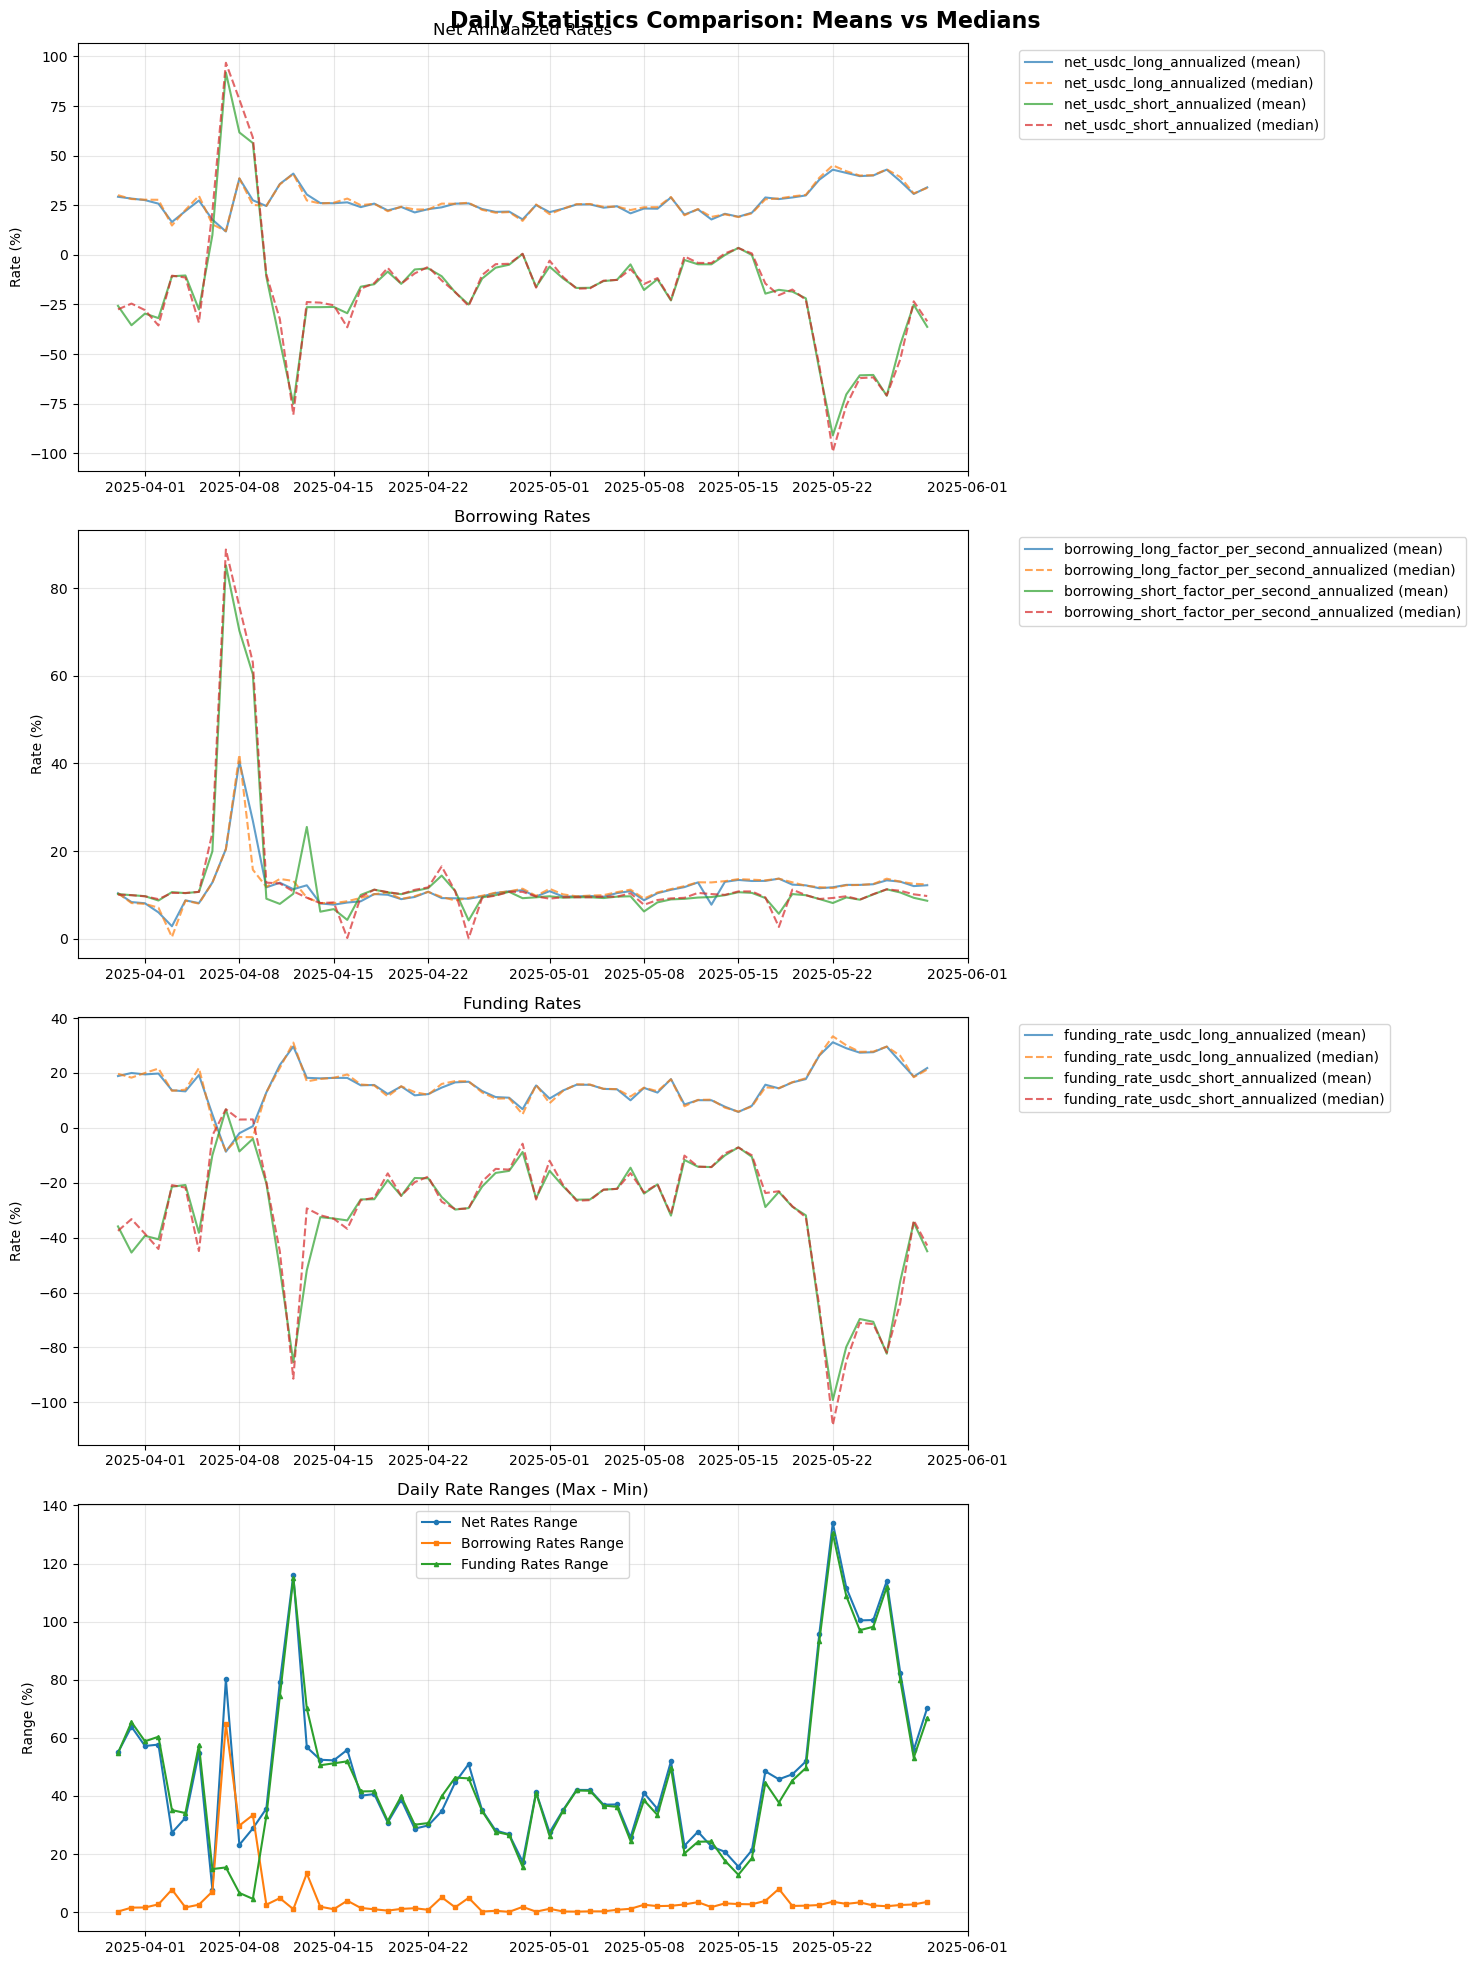

Summary Statistics:
Date range: 2025-03-30 to 2025-05-29
Total days: 61

Mean of daily means:
net_weth_long_annualized                       -125.9729
net_weth_short_annualized                        40.6693
net_usdc_long_annualized                         26.7855
net_usdc_short_annualized                       -17.8929
borrowing_long_factor_per_second_annualized      11.4428
borrowing_short_factor_per_second_annualized     12.9267
funding_rate_weth_long_annualized              -137.4157
funding_rate_weth_short_annualized               27.7426
funding_rate_usdc_long_annualized                15.3427
funding_rate_usdc_short_annualized              -30.8196
dtype: float64

Mean of daily medians:
net_weth_long_annualized                       -120.2897
net_weth_short_annualized                        39.8692
net_usdc_long_annualized                         26.9664
net_usdc_short_annualized                       -17.2749
borrowing_long_factor_per_second_annualized      11.4705
borrowing_sh

In [86]:
import matplotlib.pyplot as plt

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(4, 1, figsize=(15, 20))
fig.suptitle('Daily Statistics Comparison: Means vs Medians', fontsize=16, fontweight='bold')

# Plot 1: Net Annualized Rates
ax1 = axes[0]
for col in net_cols:
    ax1.plot(means_df.index, means_df[col], label=f'{col} (mean)', alpha=0.7)
    ax1.plot(medians_df.index, medians_df[col], label=f'{col} (median)', linestyle='--', alpha=0.7)
ax1.set_title('Net Annualized Rates')
ax1.set_ylabel('Rate (%)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Borrowing Rates
ax2 = axes[1]
for col in borrowing_cols:
    ax2.plot(means_df.index, means_df[col], label=f'{col} (mean)', alpha=0.7)
    ax2.plot(medians_df.index, medians_df[col], label=f'{col} (median)', linestyle='--', alpha=0.7)
ax2.set_title('Borrowing Rates')
ax2.set_ylabel('Rate (%)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Funding Rates
ax3 = axes[2]
for col in funding_cols:
    ax3.plot(means_df.index, means_df[col], label=f'{col} (mean)', alpha=0.7)
    ax3.plot(medians_df.index, medians_df[col], label=f'{col} (median)', linestyle='--', alpha=0.7)
ax3.set_title('Funding Rates')
ax3.set_ylabel('Rate (%)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4: Summary Statistics
ax4 = axes[3]
# Calculate daily ranges (max - min) for each category
net_range = means_df[net_cols].max(axis=1) - means_df[net_cols].min(axis=1)
borrowing_range = means_df[borrowing_cols].max(axis=1) - means_df[borrowing_cols].min(axis=1)
funding_range = means_df[funding_cols].max(axis=1) - means_df[funding_cols].min(axis=1)

ax4.plot(means_df.index, net_range, label='Net Rates Range', marker='o', markersize=3)
ax4.plot(means_df.index, borrowing_range, label='Borrowing Rates Range', marker='s', markersize=3)
ax4.plot(means_df.index, funding_range, label='Funding Rates Range', marker='^', markersize=3)
ax4.set_title('Daily Rate Ranges (Max - Min)')
ax4.set_ylabel('Range (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print("=" * 50)
print(f"Date range: {MIN_DAY_DF} to {MAX_DAY_DF}")
print(f"Total days: {len(means_df)}")
print("\nMean of daily means:")
print(means_df.mean().round(4))
print("\nMean of daily medians:")
print(medians_df.mean().round(4))
print("\nCorrelation between means and medians:")
for col in all_cols:
    corr = means_df[col].corr(medians_df[col])
    print(f"{col}: {corr:.4f}")
